In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth
from datetime import datetime
import time

In [6]:
df = pd.read_excel('Online Retail.xlsx')

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
df = df.dropna()
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.sort_values('InvoiceDate')

In [13]:
transaction_matrix = pd.crosstab(df['InvoiceNo'], df['StockCode'])
transaction_matrix = (transaction_matrix > 0).astype(int)
transaction_matrix.head()

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
invoice_dates = df.groupby('InvoiceNo')['InvoiceDate'].first().sort_values()

In [15]:
start_date = invoice_dates.min()
end_date = invoice_dates.max()

In [16]:
batches = []
batch_info = []

current_date = start_date
batch_num = 1

while current_date < end_date:

    week_end = current_date + pd.Timedelta(days=30)
    week_invoices = invoice_dates[(invoice_dates >= current_date) &
                                   (invoice_dates < week_end)].index

    if len(week_invoices) > 0:
        batch_matrix = transaction_matrix.loc[week_invoices].values
        batches.append(batch_matrix)

        batch_info.append({
            'batch': batch_num,
            'start_date': current_date.date(),
            'end_date': week_end.date(),
            'n_invoices': batch_matrix.shape[0],
            'n_products': batch_matrix.shape[1],
            'density': batch_matrix.sum() / (batch_matrix.shape[0] * batch_matrix.shape[1])
        })

        print(f"Batch {batch_num:2d} ({current_date.date()} to {week_end.date()}): "
              f"{batch_matrix.shape[0]:5d} invoices, density: {batch_info[-1]['density']:.3f}")

        batch_num += 1

    current_date = week_end

n_batches = len(batches)

Batch  1 (2010-12-01 to 2010-12-31):  1400 invoices, density: 0.005
Batch  2 (2010-12-31 to 2011-01-30):   906 invoices, density: 0.006
Batch  3 (2011-01-30 to 2011-03-01):  1078 invoices, density: 0.005
Batch  4 (2011-03-01 to 2011-03-31):  1262 invoices, density: 0.006
Batch  5 (2011-03-31 to 2011-04-30):  1208 invoices, density: 0.005
Batch  6 (2011-04-30 to 2011-05-30):  1504 invoices, density: 0.005
Batch  7 (2011-05-30 to 2011-06-29):  1340 invoices, density: 0.005
Batch  8 (2011-06-29 to 2011-07-29):  1332 invoices, density: 0.005
Batch  9 (2011-07-29 to 2011-08-28):  1281 invoices, density: 0.006
Batch 10 (2011-08-28 to 2011-09-27):  1529 invoices, density: 0.006
Batch 11 (2011-09-27 to 2011-10-27):  1929 invoices, density: 0.007
Batch 12 (2011-10-27 to 2011-11-26):  2590 invoices, density: 0.006
Batch 13 (2011-11-26 to 2011-12-26):  1173 invoices, density: 0.006


In [17]:
batches[0].sum(0)

array([16,  0,  4, ..., 22,  0, 64])

In [ ]:
from sklearn.utils.extmath import svd_flip

class IncrementalPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None
        self.var_ = None
        self.n_samples_seen_ = 0
        self.singular_values_ = None
        self.cumulative_data_ = []

    def partial_fit(self, X):
        n_samples, n_features = X.shape

        if self.components_ is None:
            self.mean_ = np.zeros(n_features)
            self.var_ = np.zeros(n_features)
            self.components_ = np.zeros((self.n_components, n_features))

        if self.n_samples_seen_ == 0:
            self.mean_ = X.mean(axis=0)
            self.var_ = X.var(axis=0)
        else:
            col_mean = X.mean(axis=0)
            col_var = X.var(axis=0)

            n_total = self.n_samples_seen_ + n_samples

            new_mean = (self.n_samples_seen_ * self.mean_ + n_samples * col_mean) / n_total

            self.var_ = (
                self.n_samples_seen_ * self.var_ +
                n_samples * col_var +
                self.n_samples_seen_ * n_samples / n_total * (self.mean_ - col_mean) ** 2
            ) / n_total

            self.mean_ = new_mean

        X_centered = X - self.mean_

        self.cumulative_data_.append(X_centered)

        self.n_samples_seen_ += n_samples

        if self.n_samples_seen_ == n_samples:
            U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
            U, Vt = svd_flip(U, Vt)

            n_comp = min(self.n_components, len(S))
            self.components_ = Vt[:n_comp]
            self.singular_values_ = S[:n_comp]
        else:
            projection = X_centered @ self.components_.T
            residual = X_centered - projection @ self.components_
            U_res, S_res, Vt_res = np.linalg.svd(residual, full_matrices=False)
            n_comp = min(self.n_components, self.components_.shape[0])
            S_diag = np.diag(self.singular_values_[:n_comp])
            top = np.hstack([S_diag, projection.T])
            bottom = np.hstack([np.zeros((Vt_res.shape[0], n_comp)),
                                np.diag(S_res)])
            K = np.vstack([top, bottom])
            U_k, S_k, Vt_k = np.linalg.svd(K, full_matrices=False)

            combined_components = np.vstack([self.components_[:n_comp], Vt_res])
            self.components_ = (Vt_k @ combined_components)[:self.n_components]
            self.singular_values_ = S_k[:self.n_components]

        all_data = np.vstack(self.cumulative_data_)
        sketch = all_data @ self.components_.T

        return sketch, self.components_


class FrequentDirections:
    def __init__(self, sketch_size):
        self.sketch_size = sketch_size
        self.sketch_ = None
        self.n_features_ = None
        self.cumulative_data_ = []

    def partial_fit(self, X):
        n_samples, n_features = X.shape

        if self.sketch_ is None:
            self.n_features_ = n_features
            self.sketch_ = np.zeros((self.sketch_size, n_features))

        self.cumulative_data_.append(X)

        for row in X:
            norms = np.linalg.norm(self.sketch_, axis=1)
            zero_rows = np.where(norms < 1e-10)[0]

            if len(zero_rows) > 0:
                self.sketch_[zero_rows[0]] = row
            else:
                U, S, Vt = np.linalg.svd(self.sketch_, full_matrices=False)
                delta = S[-1] ** 2
                S_shrunk = np.sqrt(np.maximum(S ** 2 - delta, 0))

                self.sketch_ = np.diag(S_shrunk) @ Vt

                self.sketch_[-1] = row

        U_sketch, S_sketch, Vt_sketch = np.linalg.svd(self.sketch_, full_matrices=False)

        nonzero_mask = S_sketch > 1e-10
        n_components = np.sum(nonzero_mask)

        if n_components == 0:
            n_components = 1
            nonzero_mask[0] = True

        S_sketch = S_sketch[nonzero_mask]
        Vt_sketch = Vt_sketch[nonzero_mask]

        all_data = np.vstack(self.cumulative_data_)

        projection_basis = Vt_sketch 

        sketch_compressed = all_data @ projection_basis.T

        return sketch_compressed, projection_basis


class GaussianRandomProjection:
    def __init__(self, n_components, random_state=None):
        self.n_components = n_components
        self.random_state = random_state
        self.projection_matrix_ = None
        self.inverse_projection_ = None
        self.n_features_ = None
        self.cumulative_data_ = []

    def partial_fit(self, X):
        n_samples, n_features = X.shape

        if self.projection_matrix_ is None:
            self.n_features_ = n_features
            rng = np.random.RandomState(self.random_state)

            random_matrix = rng.randn(n_features, self.n_components)

            Q, R = np.linalg.qr(random_matrix)
            self.projection_matrix_ = Q 
            self.inverse_projection_ = self.projection_matrix_.T

        self.cumulative_data_.append(X)

        all_data = np.vstack(self.cumulative_data_)
        sketch = all_data @ self.projection_matrix_

        return sketch, self.inverse_projection_


In [ ]:
def compute_metrics(original, sketch, projection):
    n_samples = original.shape[0]

    if sketch.shape[0] > n_samples:
        sketch = sketch[:n_samples, :]
    elif sketch.shape[0] < n_samples:
        padding = np.zeros((n_samples - sketch.shape[0], sketch.shape[1]))
        sketch = np.vstack([sketch, padding])

    reconstructed = sketch @ projection

    if reconstructed.shape != original.shape:
        if reconstructed.shape[0] > original.shape[0]:
            reconstructed = reconstructed[:original.shape[0], :]
        if reconstructed.shape[1] > original.shape[1]:
            reconstructed = reconstructed[:, :original.shape[1]]

    frobenius_norm = np.linalg.norm(sketch, 'fro')
    error = np.linalg.norm(original - reconstructed, 'fro') / np.linalg.norm(original, 'fro')
    original_var = np.sum(original ** 2)
    explained_var = 1 - (np.sum((original - reconstructed) ** 2) / original_var)

    return frobenius_norm, explained_var, error


In [ ]:
n_features = 3665
n_components = 50

algorithms = {
    'gaussian': GaussianRandomProjection(n_components=n_components, random_state=42),
    'frequent_directions': FrequentDirections(sketch_size=n_components),
    'incremental_pca': IncrementalPCA(n_components=n_components)
}

results = {
    'gaussian': {'norm': [], 'variance': [], 'error': [], 'time': []},
    'frequent_directions': {'norm': [], 'variance': [], 'error': [], 'time': []},
    'incremental_pca': {'norm': [], 'variance': [], 'error': [], 'time': []}
}

cumulative_matrix = None

for batch_idx, batch in enumerate(batches):
    print(f"\n{'='*60}")
    print(f"Processing Batch {batch_idx + 1} (size: {batch.shape[0]} x {batch.shape[1]})")
    print(f"{'='*60}")

    if cumulative_matrix is None:
        cumulative_matrix = batch.copy()
    else:
        cumulative_matrix = np.vstack([cumulative_matrix, batch])

    print(f"Cumulative data size: {cumulative_matrix.shape}")

    for name, algo in algorithms.items():
        start_time = time.time()

        sketch, projection = algo.partial_fit(batch)

        elapsed_time = time.time() - start_time

        norm, variance, error = compute_metrics(cumulative_matrix, sketch, projection)

        results[name]['norm'].append(norm)
        results[name]['variance'].append(variance)
        results[name]['error'].append(error)
        results[name]['time'].append(elapsed_time)

        print(f"\n{name}:")
        print(f"  Sketch shape: {sketch.shape}")
        print(f"  Projection shape: {projection.shape}")
        print(f"  Frobenius norm: {norm:.2f}")
        print(f"  Explained variance: {variance:.4f}")
        print(f"  Reconstruction error: {error:.4f}")
        print(f"  Time: {elapsed_time:.4f}s")



Processing Batch 1 (size: 1400 x 3665)
Cumulative data size: (1400, 3665)

gaussian:
  Sketch shape: (1400, 50)
  Projection shape: (50, 3665)
  Frobenius norm: 18.58
  Explained variance: 0.0136
  Reconstruction error: 0.9932
  Time: 0.1044s

frequent_directions:
  Sketch shape: (1400, 50)
  Projection shape: (50, 3665)
  Frobenius norm: 67.16
  Explained variance: 0.1782
  Reconstruction error: 0.9065
  Time: 30.4897s

incremental_pca:
  Sketch shape: (1400, 50)
  Projection shape: (50, 3665)
  Frobenius norm: 88.27
  Explained variance: 0.3079
  Reconstruction error: 0.8319
  Time: 5.9440s

Processing Batch 2 (size: 906 x 3665)
Cumulative data size: (2306, 3665)

gaussian:
  Sketch shape: (2306, 50)
  Projection shape: (50, 3665)
  Frobenius norm: 24.52
  Explained variance: 0.0135
  Reconstruction error: 0.9932
  Time: 0.0980s

frequent_directions:
  Sketch shape: (2306, 50)
  Projection shape: (50, 3665)
  Frobenius norm: 84.87
  Explained variance: 0.1622
  Reconstruction error:

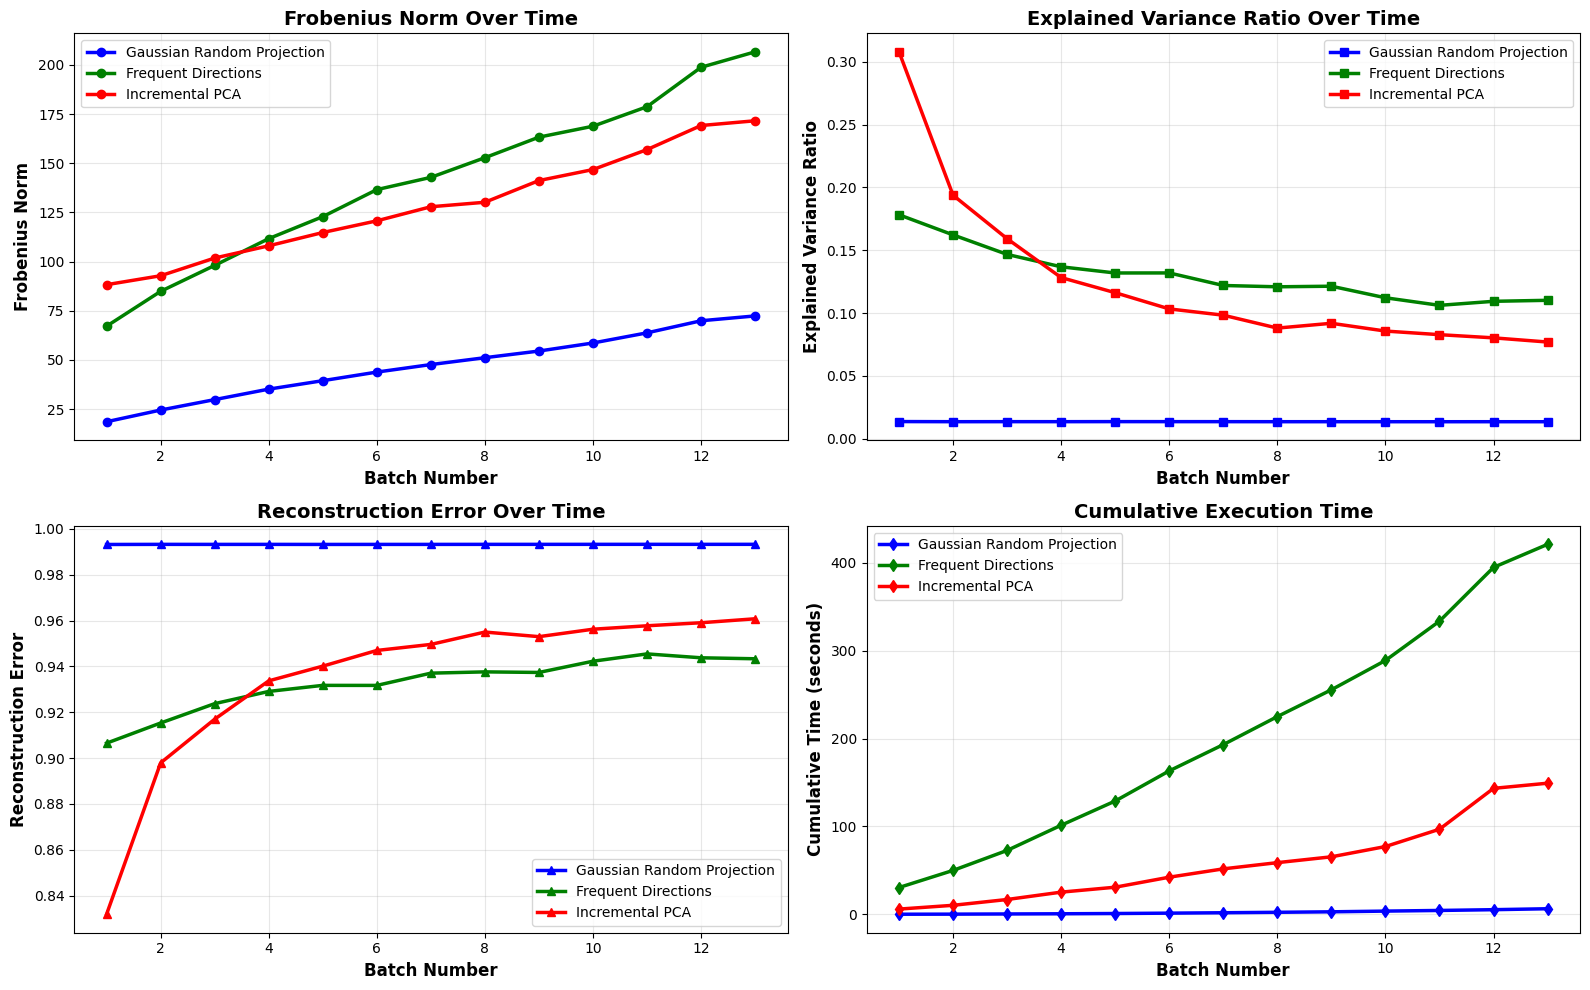

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
batch_numbers = range(1, len(batches) + 1)

colors = {'gaussian': 'blue', 'frequent_directions': 'green', 'incremental_pca': 'red'}
labels = {'gaussian': 'Gaussian Random Projection',
          'frequent_directions': 'Frequent Directions',
          'incremental_pca': 'Incremental PCA'}

ax = axes[0, 0]
for name, color in colors.items():
    ax.plot(batch_numbers, results[name]['norm'], marker='o',
           color=color, label=labels[name], linewidth=2.5, markersize=6)
ax.set_xlabel('Batch Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Frobenius Norm', fontsize=12, fontweight='bold')
ax.set_title('Frobenius Norm Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
for name, color in colors.items():
    ax.plot(batch_numbers, results[name]['variance'], marker='s',
           color=color, label=labels[name], linewidth=2.5, markersize=6)
ax.set_xlabel('Batch Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
ax.set_title('Explained Variance Ratio Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
for name, color in colors.items():
    ax.plot(batch_numbers, results[name]['error'], marker='^',
           color=color, label=labels[name], linewidth=2.5, markersize=6)
ax.set_xlabel('Batch Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Reconstruction Error', fontsize=12, fontweight='bold')
ax.set_title('Reconstruction Error Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
for name, color in colors.items():
    cumulative_time = np.cumsum(results[name]['time'])
    ax.plot(batch_numbers, cumulative_time, marker='d',
           color=color, label=labels[name], linewidth=2.5, markersize=6)
ax.set_xlabel('Batch Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Execution Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sketching_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
min_support = 0.05

print(f"\n1. Mining patterns from ORIGINAL matrix (min_support={min_support})...")
start_time = time.time()
original_patterns = apriori(transaction_matrix,
                            min_support=min_support,
                            use_colnames=True,
                            max_len=3)
original_time = time.time() - start_time
print(f"   Found {len(original_patterns)} patterns in {original_time:.2f} seconds")


1. Mining patterns from ORIGINAL matrix (min_support=0.05)...
   Found 21 patterns in 2.57 seconds


In [ ]:
def sketch_to_binary(sketch, threshold='median'):
    sketch = np.nan_to_num(sketch, nan=0.0, posinf=0.0, neginf=0.0)
    
    if threshold == 'median':
        thresh_val = np.median(sketch)
    elif threshold == 'mean':
        thresh_val = np.mean(sketch)
    elif threshold == 'zero':
        thresh_val = 0.0
    else:
        thresh_val = threshold
    
    binary_matrix = (sketch > thresh_val).astype(int)
    return binary_matrix

In [ ]:
if isinstance(transaction_matrix, pd.DataFrame):
    transaction_array = transaction_matrix.astype(bool).values.astype(np.float64)
    column_names = transaction_matrix.columns
else:
    transaction_array = transaction_matrix.astype(np.float64)
    column_names = None

In [ ]:
print(f"\n2. Mining patterns from INCREMENTAL PCA sketch...")
n_components = min(50, transaction_array.shape[1])
ipca = IncrementalPCA(n_components=n_components)

batch_size = 1000
try:
    transaction_noisy = transaction_array + np.random.randn(*transaction_array.shape) * 1e-10
    
    for i in range(0, len(transaction_noisy), batch_size):
        batch = transaction_noisy[i:i+batch_size]
        sketch, components = ipca.partial_fit(batch)
    
    start_time = time.time()
    ipca_binary = sketch_to_binary(sketch, threshold='zero')
    ipca_df = pd.DataFrame(ipca_binary.astype(bool))
    ipca_patterns = apriori(ipca_df,
                            min_support=min_support,
                            use_colnames=False,
                            max_len=3)
    ipca_time = time.time() - start_time
    print(f"   Sketch shape: {sketch.shape}")
    print(f"   Found {len(ipca_patterns)} patterns in {ipca_time:.2f} seconds")
except Exception as e:
    print(f"   ERROR: {str(e)}")
    import traceback
    traceback.print_exc()
    ipca_patterns = pd.DataFrame()
    ipca_time = 0

print(f"\n3. Mining patterns from FREQUENT DIRECTIONS sketch...")
sketch_size = min(100, transaction_array.shape[1])
fd = FrequentDirections(sketch_size=sketch_size)

try:
    for i in range(0, len(transaction_array), batch_size):
        batch = transaction_array[i:i+batch_size]
        sketch, basis = fd.partial_fit(batch)
    
    start_time = time.time()
    fd_binary = sketch_to_binary(sketch, threshold='zero')
    fd_df = pd.DataFrame(fd_binary.astype(bool))
    fd_patterns = apriori(fd_df,
                          min_support=min_support,
                          use_colnames=False,
                          max_len=3)
    fd_time = time.time() - start_time
    print(f"   Sketch shape: {sketch.shape}")
    print(f"   Found {len(fd_patterns)} patterns in {fd_time:.2f} seconds")
except Exception as e:
    print(f"   ERROR: {str(e)}")
    import traceback
    traceback.print_exc()
    fd_patterns = pd.DataFrame()
    fd_time = 0

print(f"\n4. Mining patterns from GAUSSIAN RANDOM PROJECTION sketch...")
n_components_grp = min(50, transaction_array.shape[1])
grp = GaussianRandomProjection(n_components=n_components_grp, random_state=42)

try:
    for i in range(0, len(transaction_array), batch_size):
        batch = transaction_array[i:i+batch_size]
        sketch, inverse = grp.partial_fit(batch)
    
    start_time = time.time()
    grp_binary = sketch_to_binary(sketch, threshold='zero')
    grp_df = pd.DataFrame(grp_binary.astype(bool))
    grp_patterns = apriori(grp_df,
                           min_support=min_support,
                           use_colnames=False,
                           max_len=3)
    grp_time = time.time() - start_time
    print(f"   Sketch shape: {sketch.shape}")
    print(f"   Found {len(grp_patterns)} patterns in {grp_time:.2f} seconds")
except Exception as e:
    print(f"   ERROR: {str(e)}")
    import traceback
    traceback.print_exc()
    grp_patterns = pd.DataFrame()
    grp_time = 0

In [ ]:
def create_anomaly_detection_experiment(batches, n_components=50, n_anomalies=5):

    full_matrix = np.vstack(batches[0:1])
    n_features = full_matrix.shape[1]

    print(f"Creating {n_anomalies} artificial anomalies...")

    anomalies = []
    for i in range(n_anomalies):
        anomaly = np.zeros(n_features)
        n_items = np.random.randint(n_features//4, n_features//2)
        anomaly[np.random.choice(n_features, n_items, replace=False)] = 1
        anomalies.append(anomaly)
        print(f"  Anomaly {i+1}: {n_items} items activated")

    anomalies = np.array(anomalies)
    anomaly_positions = np.linspace(100, len(full_matrix)-100, n_anomalies, dtype=int)

    matrix_with_anomalies = full_matrix.copy()
    for pos, anomaly in zip(sorted(anomaly_positions, reverse=True),
                            anomalies[::-1]):
        matrix_with_anomalies = np.insert(matrix_with_anomalies, pos, anomaly, axis=0)

    print(f"\nInserted anomalies at positions: {sorted(anomaly_positions)}")

    print("\nCreating batches of size 50...")
    batch_size = 50
    n_test_batches = len(matrix_with_anomalies) // batch_size
    test_batches = []

    for i in range(n_test_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        test_batches.append(matrix_with_anomalies[start_idx:end_idx])

    print(f"Created {n_test_batches} test batches")

    anomaly_batch_indices = sorted([pos // batch_size for pos in anomaly_positions])
    print(f"Anomalies are in batches: {anomaly_batch_indices}")

    algorithms = {
        'Gaussian RP': GaussianRandomProjection(n_components=n_components, random_state=42),
        'Frequent Directions': FrequentDirections(sketch_size=n_components),
        'Incremental PCA': IncrementalPCA(n_components=n_components)
    }

    anomaly_results = {}

    for algo_name, algo in algorithms.items():
        print(f"\nRunning {algo_name}...")
        errors = []

        for batch_idx, batch in enumerate(test_batches):
            sketch, projection = algo.partial_fit(batch)

            if algo_name == 'Incremental PCA':
                batch_centered = batch - algo.mean_
                batch_sketch = batch_centered @ projection.T
            elif algo_name == 'Gaussian RP':
                batch_sketch = batch @ algo.projection_matrix_
            else:
                U_sketch, S_sketch, Vt_sketch = np.linalg.svd(algo.sketch_, full_matrices=False)
                nonzero_mask = S_sketch > 1e-10
                if np.sum(nonzero_mask) > 0:
                    Vt_sketch = Vt_sketch[nonzero_mask]
                    batch_sketch = batch @ Vt_sketch.T
                    projection_batch = Vt_sketch
                else:
                    batch_sketch = np.zeros((batch.shape[0], 1))
                    projection_batch = np.zeros((1, batch.shape[1]))

            if algo_name == 'Incremental PCA':
                reconstructed = batch_sketch @ projection + algo.mean_
            elif algo_name == 'Gaussian RP':
                reconstructed = batch_sketch @ algo.inverse_projection_
            else: 
                reconstructed = batch_sketch @ projection_batch

            error = np.linalg.norm(batch - reconstructed, 'fro') / np.linalg.norm(batch, 'fro')
            errors.append(error)

            if batch_idx % 10 == 0:
                print(f"  Batch {batch_idx}/{n_test_batches}: error = {error:.4f}")

        anomaly_results[algo_name] = errors

    return anomaly_results, anomaly_batch_indices, test_batches


def plot_anomaly_detection(anomaly_results, anomaly_batch_indices, save_path='anomaly_detection.png'):

    print("\nGenerating visualization...")
    fig, ax = plt.subplots(figsize=(16, 6))

    n_batches = len(next(iter(anomaly_results.values())))
    batch_indices = range(n_batches)

    colors = {
        'Gaussian RP': 'blue',
        'Frequent Directions': 'green',
        'Incremental PCA': 'red'
    }

    for algo_name, errors in anomaly_results.items():
        ax.plot(batch_indices, errors, marker='o', linewidth=2,
                color=colors.get(algo_name, 'gray'), label=algo_name,
                markersize=4, alpha=0.7)

    for batch_idx in anomaly_batch_indices:
        ax.axvline(batch_idx, color='red', linestyle='--', alpha=0.5, linewidth=2)

    ax.set_xlabel('Batch Index', fontsize=12, fontweight='bold')
    ax.set_ylabel('Reconstruction Error', fontsize=12, fontweight='bold')
    ax.set_title('Anomaly Detection: Reconstruction Error Across All Algorithms',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)

    y_max = max([max(errors) for errors in anomaly_results.values()])
    for batch_idx in anomaly_batch_indices:
        ax.text(batch_idx, y_max * 0.95, f'Anomaly\nBatch {batch_idx}',
                ha='center', va='top', fontsize=8, color='red',
                fontweight='bold', bbox=dict(boxstyle='round',
                facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {save_path}")


def analyze_anomaly_scores(anomaly_results, anomaly_batch_indices):

    print("\n" + "="*60)
    print("ANOMALY DETECTION ANALYSIS")
    print("="*60)

    for algo_name, errors in anomaly_results.items():
        print(f"\n{algo_name}:")

        anomaly_errors = [errors[i] for i in anomaly_batch_indices if i < len(errors)]
        normal_errors = [errors[i] for i in range(len(errors)) if i not in anomaly_batch_indices]

        if anomaly_errors and normal_errors:
            avg_anomaly_error = np.mean(anomaly_errors)
            avg_normal_error = np.mean(normal_errors)
            std_normal_error = np.std(normal_errors)

            print(f"  Average error on anomaly batches: {avg_anomaly_error:.4f}")
            print(f"  Average error on normal batches: {avg_normal_error:.4f}")
            print(f"  Std dev on normal batches: {std_normal_error:.4f}")
            print(f"  Detection ratio: {avg_anomaly_error / avg_normal_error:.2f}x")


Creating 5 artificial anomalies...
  Anomaly 1: 1544 items activated
  Anomaly 2: 1264 items activated
  Anomaly 3: 1780 items activated
  Anomaly 4: 1143 items activated
  Anomaly 5: 1635 items activated

Inserted anomalies at positions: [np.int64(100), np.int64(400), np.int64(700), np.int64(1000), np.int64(1300)]

Creating batches of size 50...
Created 28 test batches
Anomalies are in batches: [np.int64(2), np.int64(8), np.int64(14), np.int64(20), np.int64(26)]

Running Gaussian RP...
  Batch 0/28: error = 0.9929
  Batch 10/28: error = 0.9934
  Batch 20/28: error = 0.9909

Running Frequent Directions...
  Batch 0/28: error = 0.0000
  Batch 10/28: error = 0.3791
  Batch 20/28: error = 0.2477

Running Incremental PCA...
  Batch 0/28: error = 0.0000
  Batch 10/28: error = 0.9115
  Batch 20/28: error = 0.6269

Generating visualization...


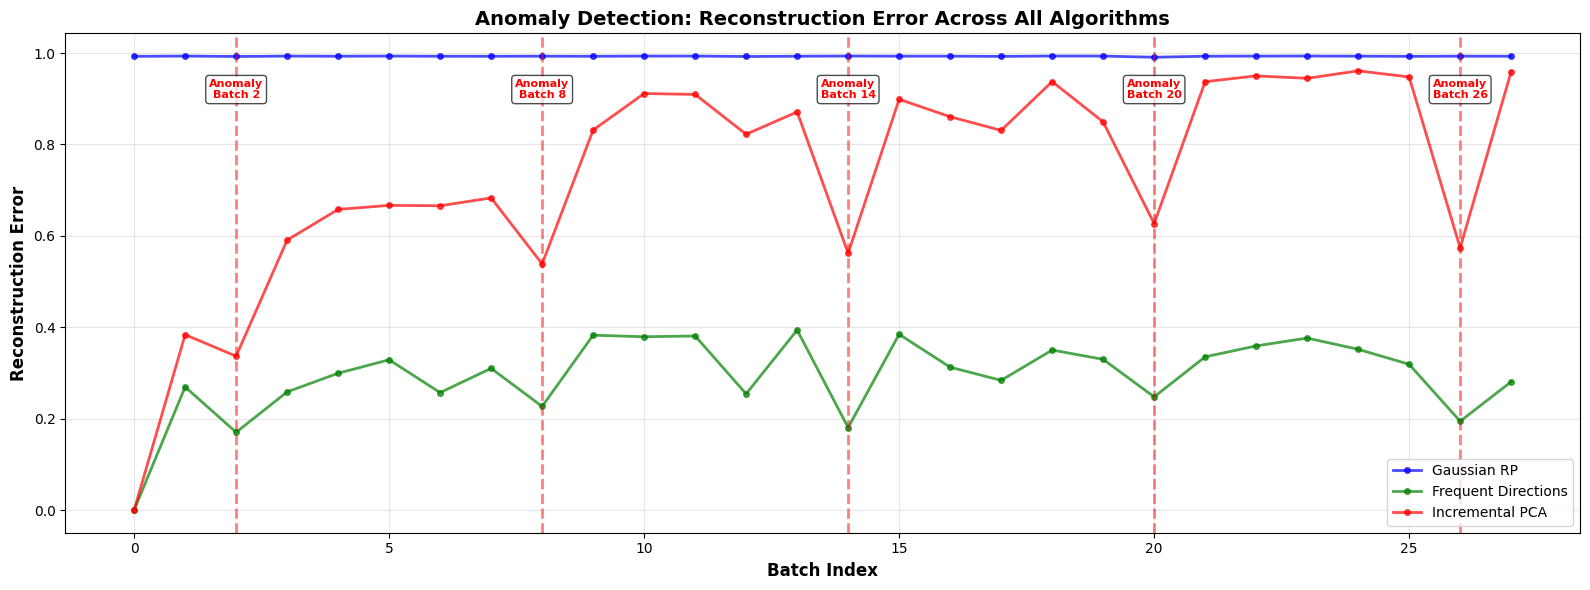

Plot saved to anomaly_detection.png

ANOMALY DETECTION ANALYSIS

Gaussian RP:
  Average error on anomaly batches: 0.9927
  Average error on normal batches: 0.9932
  Std dev on normal batches: 0.0003
  Detection ratio: 1.00x

Frequent Directions:
  Average error on anomaly batches: 0.2039
  Average error on normal batches: 0.3129
  Std dev on normal batches: 0.0800
  Detection ratio: 0.65x

Incremental PCA:
  Average error on anomaly batches: 0.5275
  Average error on normal batches: 0.7857
  Std dev on normal batches: 0.2211
  Detection ratio: 0.67x


In [ ]:
n_components = 50
anomaly_results, anomaly_batch_indices, test_batches = create_anomaly_detection_experiment(
    batches,
    n_components=n_components,
    n_anomalies=5
)

plot_anomaly_detection(anomaly_results, anomaly_batch_indices)
analyze_anomaly_scores(anomaly_results, anomaly_batch_indices)